In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

%matplotlib inline

# The 4 equations of the Hodgkin-Huxley model  

($V$: Membrane Potential)

* $C_M\displaystyle \frac{dV}{dt}=-g_{Na}\;\;(V-E_{Na})-g_k\;\;(V-E_K)-g_L\;\;(V-E_L)+I$   


($h$: Na Inactivation)  

* $\displaystyle \frac{dh}{dt}=\alpha_h{(V)}\;\;(1-h)-\beta_h(V)h$ 


($m$: Na Activation) 

* $\displaystyle \frac{dm}{dt}=\alpha_m{(V)}\;\;(1-m)-\beta_m(V)m$ 


($n$: K Activation)  

* $\displaystyle \frac{dn}{dt}=\alpha_n{(V)}\;\;(1-n)-\beta_n(V)n$ 

#### Task 1  

The Hodgkin Huxley class is already implemented, in a similar way as we implemented the LIF class in the previous exercises. 
Execute the cell below. This will run the function 'run_sim_and_show_lecture_plot()' that will generate the plot for the Hodgkin Huxley spike as you have seen in the lecture. 

Please go through the class and see whether the implementation makes sense to you
(it might make sense to start with the 'run_simulation' class and then move through the functions that are called). 
What are significant differences on the implementation level when you compare this class to the LIF class?


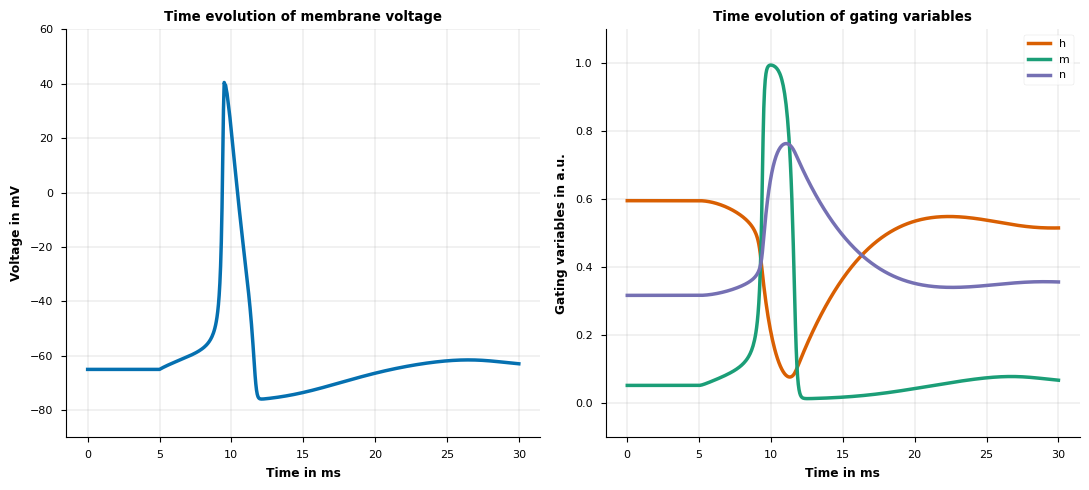

In [288]:
class HodgkinHuxleyNeuron(object):
    """A class to model the Hodgkin Huxley formalism for a spiking neuron
       The methods allow to run the simulation and plot the results
    """
    def __init__(self, 
                 g_na=120, # mS/cm2
                 g_k=36, # mS/cm2
                 g_l=0.3, # mS/cm2
                 e_na = 50, # mV
                 e_k  = -77, # mV
                 e_l  = -54.4, # mV
                 c_m = 1, # micro F/cm2
                 i_e = 0, # mu A /cm2,
                 dt = 0.05, # in ms
                ):
        '''This function is executed when we create an object from that class'''
        super(HodgkinHuxleyNeuron, self).__init__()

        ### assign the attributes of the class   
              
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep in ms    

        # maximum conductances
        self.g_na = g_na #g_na 
        self.g_k = g_k # g_k
        self.g_l = g_l # g_l
        
        # reveral potentials
        self.e_na = e_na # e_na
        self.e_k  = e_k # e_k
        self.e_l  = e_l # e_l
        
        # membrane capacitance
        self.c_m = c_m
        
        self.i_e = i_e # Input current        
        
        # initialize the gating parameters
        self.h = 0
        self.m = 0
        self.n = 0.5
        
        self.i_na = 0
        self.i_k = 0
        self.i_l = 0
        
        
        # initiate colors 
        self.color_h = '#D95F02'
        self.color_m = '#1B9E77'
        self.color_n = '#7570B3'
        
         # we need to run this function once to initilize the lists
        self.reset_lists()
        
        # when initiating, we run the model once, so that all the paramters (v, m, h, n)
        # settle in the steady state, then we reset the lists
        self.run_simulation(4000)
        self.reset_lists()
        
        
    def reset_lists(self):
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]
        
        self.m_list = [self.m]
        self.n_list = [self.n]
        self.h_list = [self.h]
        
        self.i_na_list = [self.i_na]
        self.i_k_list = [self.i_k]
        self.i_l_list = [self.i_l]
        
        self.i_e_list = [0]
        
        
        
    # define all the alpha and beta functions
    # this is simply the implementation of all the functions defined in the lecture
    def alpha_h(self, v):
        alpha_h = 0.07 * np.exp(-0.05*(v + 65))
        return alpha_h
    
    def beta_h(self, v):
        beta_h  = 1. / (1 + np.exp(-0.1*(v + 35)))
        return beta_h
    
    def alpha_m(self, v):
        alpha_m = 0.1 * (v + 40) / (1 - np.exp(-0.1*(v + 40)))
        return alpha_m
    
    def beta_m(self, v):
        beta_m  = 4. * np.exp(-0.0556*(v + 65))
        return beta_m
    
    def alpha_n(self, v):
        alpha_n = 0.01 * (v + 55) / (1-np.exp(-0.1*(v+55)))
        return alpha_n
    
    def beta_n(self, v):
        beta_n  = 0.125 * np.exp(-0.0125*(v + 65))
        return beta_n
    
        

    def delta_v(self):
        # the change for one timestep of V
        
        # we first calculate the currents through each channel type
        self.i_na = self.g_na * self.h * (self.m**3) * (self.v - self.e_na)
        self.i_k = self.g_k * (self.n**4) * (self.v - self.e_k)
        self.i_l = self.g_l * (self.v - self.e_l)
        
        delta_v = (- self.i_na - self.i_k - self.i_l + self.i_e) * self.dt / self.c_m
        
        return delta_v

    def delta_h(self):
        # the change for one timestep of h
        alpha = self.alpha_h(self.v)
        beta = self.beta_h(self.v)
        h = self.h
        delta_h = (alpha * (1 - h) - beta * h) * self.dt        
        return delta_h

    def delta_m(self):
        # the change for one timestep of m
        alpha = self.alpha_m(self.v)
        beta = self.beta_m(self.v)
        m = self.m
        delta_m = (alpha * (1 - m) - beta * m) * self.dt
        
        return delta_m

    def delta_n(self):
        # the change for one timestep of n
        alpha = self.alpha_n(self.v)
        beta = self.beta_n(self.v)
        n = self.n
        delta_n = (alpha * (1 - n) - beta * n) * self.dt
        
        return delta_n

    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        self.v += self.delta_v()
        self.h += self.delta_h()
        self.m += self.delta_m()
        self.n += self.delta_n()
        
        # append all the values to lists to save the data
        self.v_list.append(self.v)
        self.h_list.append(self.h)
        self.m_list.append(self.m)
        self.n_list.append(self.n)

        self.i_k_list.append(self.i_k)
        self.i_na_list.append(self.i_na)
        self.i_l_list.append(self.i_l)
        
        self.i_e_list.append(self.i_e)
        current_time = self.t_list[-1] + self.dt
        self.t_list.append(current_time) 


    def run_simulation(self, time_steps = 100, 
                        i_e_array = np.array([]), # we can provide an array for the input current. 
                         # If none is provided or the current timestep is bigger than the array length, self.i_e is taken
                         ):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        for ii in range(time_steps):
            
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                self.i_e = i_e_array[ii]
                
            self.timestep()
            
    def plot_voltage_and_gating(self):
        
        fig, axes = plt.subplots(1,2, figsize=(11,5))
        axes[0].plot(self.t_list,self.v_list,linewidth=2.5, c='#0570B0')
        axes[1].plot(self.t_list,self.h_list,linewidth=2.5, label= 'h', c=self.color_h)
        axes[1].plot(self.t_list,self.m_list,linewidth=2.5, label= 'm', c =self.color_m)
        axes[1].plot(self.t_list,self.n_list,linewidth=2.5, label= 'n', c =self.color_n )

        axes[0].set(
            title = 'Time evolution of membrane voltage',
            xlabel = 'Time in ms',
            ylabel = 'Voltage in mV',
            ylim = [-90,60],
            )
        axes[1].set(
            title = 'Time evolution of gating variables',
            xlabel = 'Time in ms',
            ylabel = 'Gating variables in a.u.',
            ylim = [-0.1,1.1]
            )
        axes[1].legend()
        plt.tight_layout() # This makes the plot cleaner, you can try how it looks if you remove this part
        
        
    def plot_voltage_with_input_current(self):
        
        fig, axes = plt.subplots(2, figsize=(8,7))
        axes[0].plot(self.t_list,self.v_list,linewidth=2.5, c='#0570B0')
        axes[1].plot(self.t_list,self.i_e_list,linewidth=2.5, label= 'input current', c=self.color_h)

        axes[0].set(
            title = 'Time evolution of membrane voltage',
            xlabel = 'Time in ms',
            ylabel = 'Voltage in mV',
            ylim = [-90,60],
            )
        axes[1].set(
            xlabel = 'Time in ms',
            ylabel = r'Input current in $\mu F/cm^2$ ',
            ylim = [-0.1,10],
            )
        axes[1].legend()
        plt.tight_layout() # This makes the plot cleaner, you can try how it looks if you remove this part
        
            
    def run_sim_and_show_lecture_plot(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        self.run_simulation(100)
        self.i_e = 3
        self.run_simulation(500)
        self.plot_voltage_and_gating()
        
        
    def show_steady_state_gating_and_time_constants(self):
        
        fig, axes = plt.subplots(1,2,figsize = (8,4))
        
        x = np.linspace(-110,70,1000)

        m_inf = self.alpha_m(x)/(self.alpha_m(x) + self.beta_m(x))
        h_inf = self.alpha_h(x)/(self.alpha_h(x) + self.beta_h(x))
        n_inf = self.alpha_n(x)/(self.alpha_n(x) + self.beta_n(x))
        axes[0].plot(x, m_inf, label=r'$m_{\infty}$',color=self.color_m)
        axes[0].plot(x, h_inf, label=r'$h_{\infty}$',color=self.color_h)
        axes[0].plot(x, n_inf, label=r'$n_{\infty}$',color=self.color_n)
        
        tau_m = 1/(self.alpha_m(x) + self.beta_m(x))
        tau_h = 1/(self.alpha_h(x) + self.beta_h(x))
        tau_n = 1/(self.alpha_n(x) + self.beta_n(x))
        axes[1].plot(x, tau_m, label=r'$\tau_m$',color=self.color_m)
        axes[1].plot(x, tau_h, label=r'$\tau_h$',color=self.color_h)
        axes[1].plot(x, tau_n, label=r'$\tau_n$',color=self.color_n)
        
        axes[0].set(
            title = 'steady state gating variables',
            xlabel = 'Membrane voltage in mV',
            ylabel = 'Open probability'
        )
        axes[1].set(
            title = 'gating time constants',
            xlabel = 'Membrane voltage in mV',
            ylabel = 'Open probability'
        )
        
        axes[0].legend()
        axes[1].legend()

        
model_lecture = HodgkinHuxleyNeuron()
model_lecture.run_sim_and_show_lecture_plot()


There are some methods already included in the class. One you already used above, they are included in the method run_sim_and_show_lecture_plot() : 

When you created a model like for example

```python
example_model = HodgkinHuxleyNeuron()
```
you can use the same mehtod you are used to from the LIF model class to run the simulation 
```python
example_model.run_simulation(time_steps = 200)
```

Once the simulatin is run, you can show the results with two possible methods. 
1)
```python
example_model.plot_voltage_and_gating()
```
will create a figure that contains the voltage trace on the left and the dynamics of the gating variables on the right.
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_3/static/example_voltage_and_gating.png" width="650"/>
</div>


The second one:
```python
example_model.plot_voltage_and_gating()
```
will show you the voltage trace combined with the input current that has been induced over the simulation. 
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_3/static/example_voltage_and_input.png" width="650"/>
</div>


The method 
```python
example_model.show_steady_state_gating_and_time_constants()
```
is independent of a run and calculates (using alpha and beta as defined in the class) the steady state gating variables and time constants and shows them in a plot. 
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_3/static/steady_state_gating_and_time_constants.png" width="650"/>
</div>



As you can see in the method
```python 
def run_sim_and_show_lecture_plot(self):
    '''
        Function to plot the simulated results
        creates a figure and plots the voltage traces vs. the simulated time
    '''

    self.run_simulation(100)
    self.i_e = 3
    self.run_simulation(500)
    self.plot_voltage_and_gating()
```

you can change the input current $i_e$ in between runs as we did before with the LIF model class. 
However, for more complex input patterns I now added another possibility. 

We now use numpy arrays for this (they behave in many ways like lists). You can generate the same output as with the above method now with the following implementation:

```python

sim_len = 600

i_e = np.zeros(sim_len) 
# making the array the same lenght as the simulation ensures that it behaves like we plan to
i_e[100:] = 3
self.run_simulation(sim_len)
self.plot_voltage_and_gating()

```


For the following tasks you can now use these functions, or you can write your own code. 
Remember that you can always access the attributes of a class 

when you are writing a method (a function that belongs to the class)
```python
def example_method(self):
    
    example_attribute = self.t_list
    
```

or when you are accessing them outside the class
```python
example_object = HodgkinHuxleyNeuron()
example_attribute = example_object.t_list
```


this allows you for example to make different instancens of the HodgkinHuxleyNeuron class with different parameters and show the results in the same figure (and idea that might help for task 3 and following)



### Task 2

Above and in the lecture we have induced a current into the neuron model and have seen a spike in response. Can you implement a run that also induces a current but there is no spike? 
Can you think of distinct ways of **not** inducing a spike with a current?

What do you observe in the membrane potential even if there is no spike?

### Solution 2

```python
def no_spike_1():
    
    # we will not generate a spike if the current is too small
    model = HodgkinHuxleyNeuron()
    model.run_simulation(100)
    model.i_e = 2.1
    model.run_simulation(500)
#     model.plot_voltage_and_gating()
    model.plot_voltage_with_input_current()

def no_spike_2():
    
    # we will also not generate a spike if the current pulse is too short
    model = HodgkinHuxleyNeuron()
    model.run_simulation(100)
    model.i_e = 10
    model.run_simulation(12)
    model.i_e = 0.0
    model.run_simulation(500)
#     model.plot_voltage_and_gating()
    model.plot_voltage_with_input_current()

no_spike_1()       
no_spike_2()
```

### What happened? 

In both cases we cannot activate the Na - self-exciting loop, such that the neuron does not spike. However, we still see the effect, that we have a small undershoot after the initial rise, even when the current remains, this is again due to the K+ channel that opens already du to the small depolarization we induced. 

#### Task 3

We now want to investigate the effect of different maximum conudctance strenghts for the Na channel (g_na)

Create a plot that shows the voltage trace given a steady input current of i_e = 3 $\mu F/cm^2$ for the different maximum conductance values g_na in of 80, 100, 120 & 140. 

What happens with the action potential, did you expect that? 


### Solution 3


### Before you read on

Maybe you encountered weird artifacts? 
It helps to change the timestep (when creating the model):

``` python
model_dummy = HodgkinHuxleyNeuron(g_na=g_na, dt=0.01)
```





### If you want to see the solution:


```python

fig, ax = plt.subplots(figsize = [11,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, g_na in zip(colors,[80,100, 120, 140]):
    model_dummy = HodgkinHuxleyNeuron(g_na=g_na, dt=0.01)
    
    model_dummy.run_simulation(500)
    model_dummy.i_e = 3
    model_dummy.run_simulation(2500)
    ax.plot(model_dummy.t_list, model_dummy.v_list, color = color, label = f"{g_na}")
    
ax.set(
    title = 'Membrane Potential $V$ for different values of $g_{Na}$',
    xlabel = '$t$ (ms)',
    ylabel = '$V$ (mV)',
    ylim = (-82,45)
)    
ax.legend(title = r"$g_{Na}$ in $\frac{mS}{cm^2}$" )
          
```

### what happened

You can see two main effects on the shape of the spike:

1) It shifts to the right with smaller g_na. This happens because we need to reach higher voltage values to enter the self-excciting loop of the Na-channel (and this takes more time). If the maximum conductance is too small, we actually see no spike at all.

2) It becomes smaller in amplitude with smaller g_na. The maximum current we can induce is smaller if g_max is smaller which means that g_K will be more dominant when the spike happens. 



#### Task 4

We now want to investigate the effect of different maximum conudctance strenghts for the K channel (g_k)

Create a plot that shows the voltage trace given a steady input current of i_e = 3 $\mu F/cm^2$ for the different maximum conductance values g_k in of 20, 30, 40 & 50. 

What happens with the action potential, did you expect that? 

### Solution 4


### Before you read on

Maybe you encountered weird artifacts? 
It helps to change the timestep (when creating the model):

``` python
model_dummy = HodgkinHuxleyNeuron(g_k=g_k, dt=0.01)
```





### If you want to see the solution:


```python

fig, ax = plt.subplots(figsize = [11,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, g_k in zip(colors,[20,30,40,50]):
    model_dummy = HodgkinHuxleyNeuron(g_k=g_k, dt= 0.01)
    
    model_dummy.run_simulation(500)
    model_dummy.i_e = 3
    model_dummy.run_simulation(2500)
    ax.plot(model_dummy.t_list, model_dummy.v_list, color = color, label = f"{g_k}")

    
ax.set(
    title = 'Membrane Potential $V$',
    xlabel = '$t$ (ms)',
    ylabel = '$V$ (mV)',
    ylim = (-82,45)
)    
ax.legend(title = r"$g_{K}$ in $\frac{mS}{cm^2}$" )
          
```

### what happened

The spike shifts to the left with smaller g_na. This happens because we now more easily reach higher voltage values to enter the self-excciting loop of the Na-channel because there is less K+ current already during small depolarizations. If the maximum conductance is too small, we already see spikes even with no input. the Na currents can always enter the self-excitation loop.

If g_na is too big, there will be no spike at all. We also see that the action potential becomes smaller in amplitude for higher g_k values.

### Task 5

We now want to investigate 

### solution 5

One way of illustrating the refractory period is the following:

<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_3/static/refractory_example.png" width="650"/>
</div>


### Taks 6

Implement your idea ( or the idea presented in solution 5) of how to illustrate the refractory period


### Solution 6

``` python

def illustrate_refractory_period():
    sim_len = 600

    i_e = np.zeros(sim_len)
    for ii in [100,250,400]:
        i_e[ii:ii + 75] = 6

    model = HodgkinHuxleyNeuron()
    model.run_simulation(sim_len, i_e_array = i_e)
    model.plot_voltage_with_input_current()
    # model.plot_voltage_and_gating()
    
illustrate_refractory_period()

```

In [218]:
class LIFNeuron(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 c_m = 1, r_m = 10, v_reset = -70, refrac_time = 10, v_th = -50, e_l = -75, i_e = 0, dt = 0.05,
                ):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()

        ### assign the attributes of the class
        self.r_m = r_m # membrane resistance in M Ohm/cm**2
        self.tau_m = self.r_m * c_m  # membrane time constant
        self.e_l = e_l # leak reversal potential

        
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.i_e = i_e # Input current


        self.v = self.e_l # starting voltage value for the simulation
        self.dt = dt # simulation timestep    

        
        
        self.refrac_time = refrac_time # in ms
        self.refrac_tracker = 0
        
        self.v_list = [self.v]
        self.t_list = [0]
        self.i_e_list = [self.i_e]


    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        if self.refrac_tracker > 0:
            self.refrac_tracker -= self.dt
            return
        
        ### Time evolution of the membrane potential
        if self.v <= self.v_th:
            dv_dt = (-self.v + self.e_l + self.r_m * self.i_e)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            # here we implement a spiking behavior (mainly just for the look)
            if self.v != 40:
                self.v = 40
            else:
                self.v = self.v_reset
                self.refrac_tracker = self.refrac_time


    def run_simulation(self, time_steps = 100, i_e_array = np.array([]), # we can provide an array for the input current. 
                 # If none is provided or the current timestep is bigger than the array length, self.i_e is taken
                      ):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''

        for ii in range(time_steps):
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                self.i_e = i_e_array[ii]
            
            
            self.timestep()

            
            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 
            self.i_e_list.append(self.i_e)

In [219]:

def test(c_m = 0.8, r_m = 2.9, refrac_time = 12.5, e_l = -65.5):
    
    sim_len = 1000

    I_input = np.zeros(sim_len)
    I_input[100:600] = 8
#     for ii in [100,250,400]:
#         I_input[ii:ii + 75] = 5


    lif_model = LIFNeuron(c_m=c_m, r_m = r_m, refrac_time = refrac_time, e_l = e_l)
    hh_model = HodgkinHuxleyNeuron()

    lif_model.run_simulation(sim_len, i_e_array = I_input)
    hh_model.run_simulation(sim_len, i_e_array = I_input)


    fig, axes = plt.subplots(2)
    axes[0].plot(hh_model.t_list, hh_model.v_list)
    axes[0].plot(lif_model.t_list, lif_model.v_list)
    
    axes[1].plot(hh_model.t_list, hh_model.i_e_list)
    axes[1].plot(lif_model.t_list, lif_model.i_e_list)

    axes[0].set(
        ylim = [-80,50]
    )
    
    axes[1].set(
        
    )

widgets.interact(test, c_m = (0.01, 5,0.01), r_m = (0.1,20,0.2), refrac_time=(1,20,0.5), e_l = (-80,-60,0.5) )

interactive(children=(FloatSlider(value=0.8, description='c_m', max=5.0, min=0.01, step=0.01), FloatSlider(val…

<function __main__.test(c_m=0.8, r_m=2.9, refrac_time=12.5, e_l=-65.5)>

In [9]:
def run_simulation(
    ### simulation parameters ###
   
    dt = 0.01,      # time step (ms)
    T = 55,       # total running time (ms)
    
    
    ### model paramters ###
    C_m = 1.,       # membrane capacitance (micro F/cm**2)
    
    # Sodium Channel
    G_Na = 120.,    # max Na conductance (mS/cm**2)
    E_Na = 115.,    # Na reversal potential (mV)
    
    # Kalium Channel
    G_K = 40.,      # max K conductance (mS/cm**2)
    E_K = -12.0,    # K reversal potential (mV)
    
    # Leak current    
    G_L = 0.24,     # max leak onductance (mS/cm**2)
    E_L = 10.613,   # leak potential (mV)
    
    flag = 'spike'
    ):
    
    par_dict = dict(
    C_m = C_m,
    G_Na = G_Na,
    E_Na = E_Na,
    G_K  = G_K,
    E_K  = E_K,
    G_L  = G_L,
    E_L  = E_L,
    )
    # initialize the simulation parameters
    V_m = 0 # membrane potential (mV)
    m_Na = 0 # Na channel activation (dimensionless)
    h_Na = 0 # Na channel inactivation (dimensionless)
    n_K = 0 # K channel activation (dimensionless)

    # total membrane current (microA/cm**2) for the time of the simulation
   
    I_input = np.array([0] * int(T/dt))
    if flag == 'spike':
        I_input[1500:1800] = 10
    if flag == 'burst':
        I_input[1500:] = 10
    if flag == 'refractory':
        for ii in [1500,2100,2700]:
         I_input[ii:ii + 300] = 10
    Time = [ii*dt for ii in range(int(T/dt))]


    result_V_m, result_m_Na, result_h_Na, result_n_K = ([] for i in range(4))
    for t in range(int(100 // dt)):
        V_m, m_Na, h_Na, n_K = update(v=V_m, m=m_Na, h=h_Na, n=n_K, i=0, dt=dt, par_dict = par_dict)
    for t in range(len(I_input)):
        V_m, m_Na, h_Na, n_K = update(v=V_m, m=m_Na, h=h_Na, n=n_K, i=I_input[t], dt=dt, par_dict = par_dict)
        result_V_m.append(V_m)
        result_m_Na.append(m_Na)
        result_h_Na.append(h_Na)
        result_n_K.append(n_K)
    return result_V_m, result_m_Na, result_h_Na, result_n_K, I_input, Time

In [10]:
def plot_current(Time, Current):
    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)')
    plt.ylabel('$I$ $\mathrm{(\mu A/cm^2)}$')
    # plt.xlim(-1, 30)
    plt.ylim(-2, 12)
    plt.plot(Time, Current)
    plt.title('Input Current $I$')
    
def plot_membrane_potential(Time, Voltage):

    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)')
    plt.ylabel('$V$ (mV)')
    plt.ylim(-20, 120)
    plt.plot(Time, Voltage, color = '#bd0026')
    title = plt.title('Membrane Potential $V$')

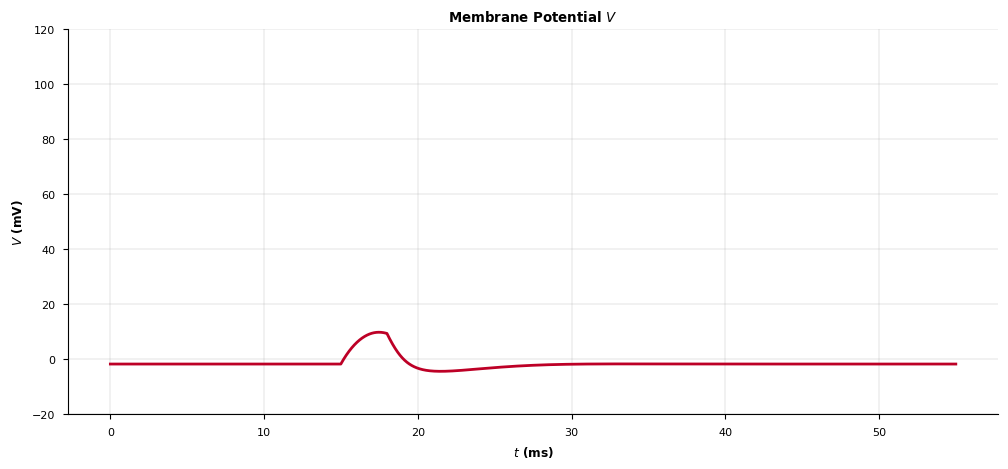

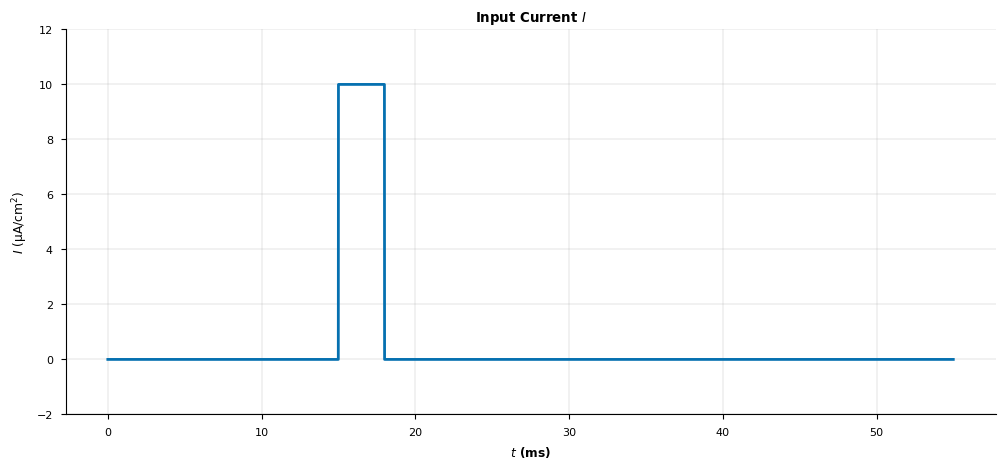

In [11]:
Voltage,m,h,n,I,Time = run_simulation(
### simulation parameters ###
   
    dt = 0.01,      # time step (ms)
    T = 55,       # total running time (ms)
    
    
    ### model paramters ###
    C_m = 1.,       # membrane capacitance (micro F/cm**2)
    
    # Sodium Channel
    G_Na = 10,    # max Na conductance (mS/cm**2)
    E_Na = 115.,    # Na reversal potential (mV)
    
    # Kalium Channel
    G_K = 40.,      # max K conductance (mS/cm**2)
    E_K = -12.0,    # K reversal potential (mV)
    
    # Leak current    
    G_L = 0.24,     # max leak onductance (mS/cm**2)
    E_L = 10.613,   # leak potential (mV)
    
    flag = 'spike'
)

plot_membrane_potential(Time = Time, Voltage = Voltage)
plot_current(Time = Time, Current = I)

NameError: name 'run_simulation' is not defined

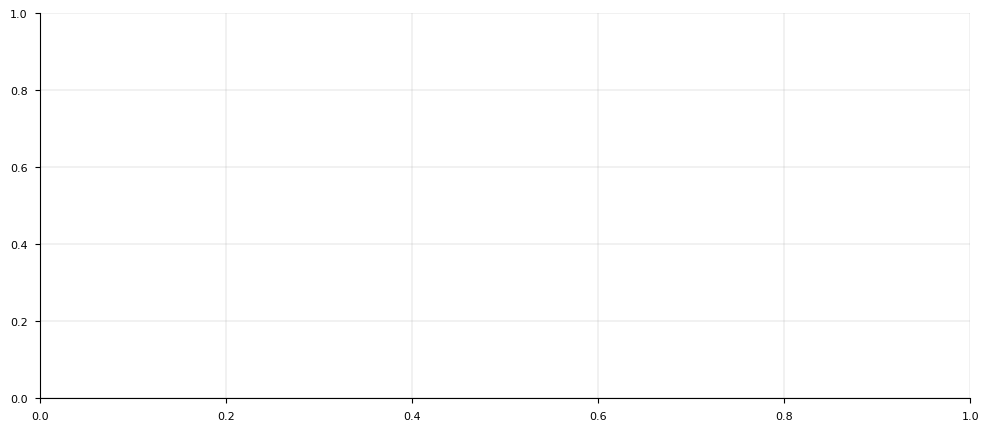

In [251]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, G_Na in zip(colors,[20,70, 120, 170]):
    V_membrane,_,_,_,_,Time = run_simulation(G_Na = G_Na)
    ax.plot(Time, V_membrane, color = color, label = f"{G_Na}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$ for different values of $g_K$')
ax.legend(title = "G_Na in mS/cm**2" )

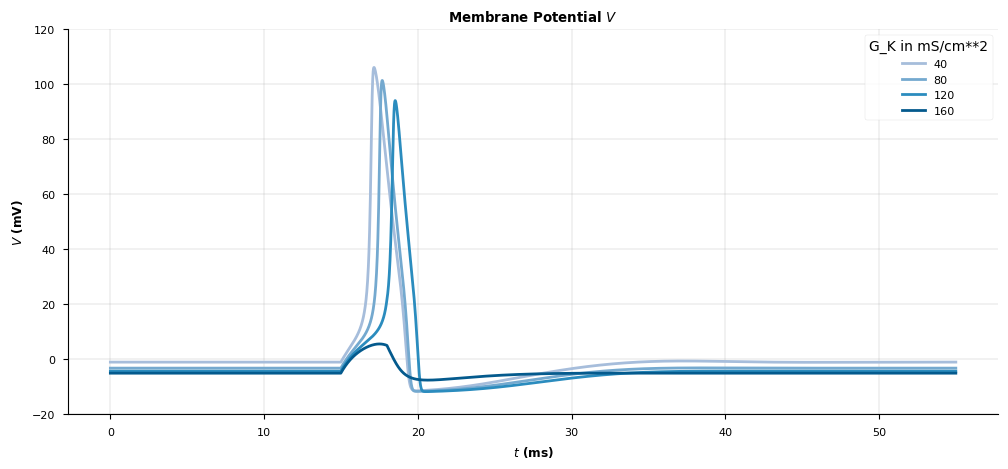

In [13]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, G_K in zip(colors,[40,80, 120, 160]):
    V_membrane,_,_,_,_,Time = run_simulation(G_K = G_K)
    ax.plot(Time, V_membrane, color = color, label = f"{G_K}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "G_K in mS/cm**2" )

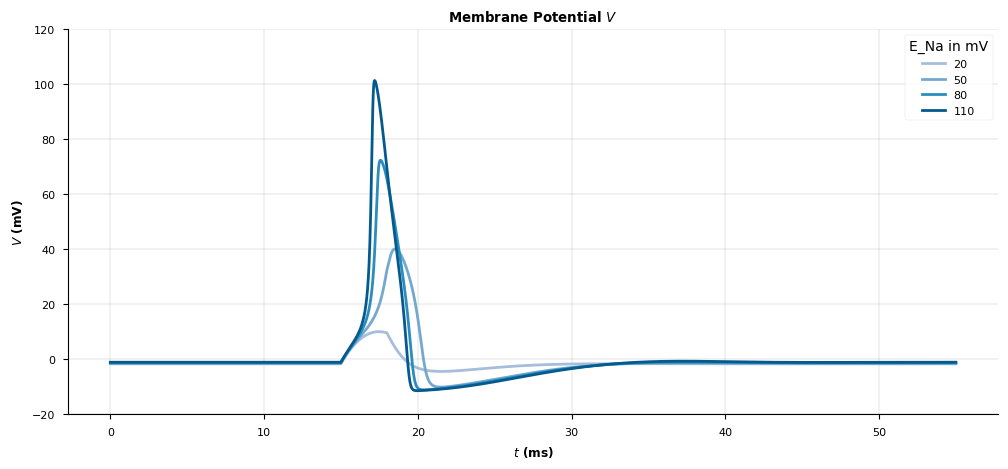

In [14]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, E_Na in zip(colors,[20,50, 80, 110]):
    V_membrane,_,_,_,_,Time = run_simulation(E_Na = E_Na)
    ax.plot(Time, V_membrane, color = color, label = f"{E_Na}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "E_Na in mV" )

Text(0.5, 1.0, 'Ion Channel Activation')

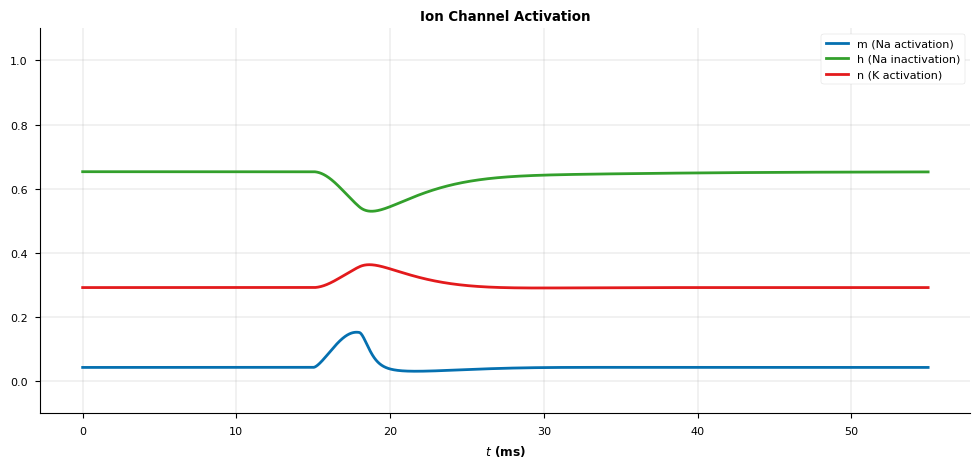

In [15]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time, m)
plt.plot(Time, h)
plt.plot(Time, n)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')

## Refractory Period

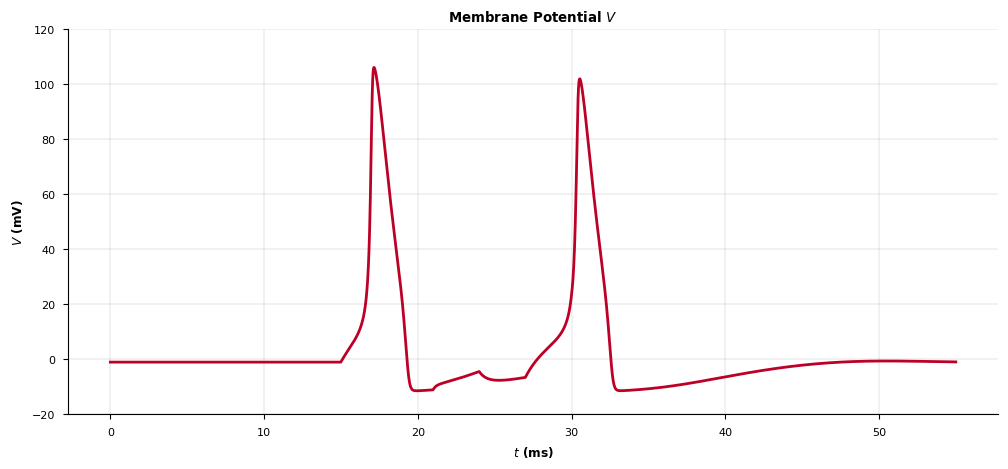

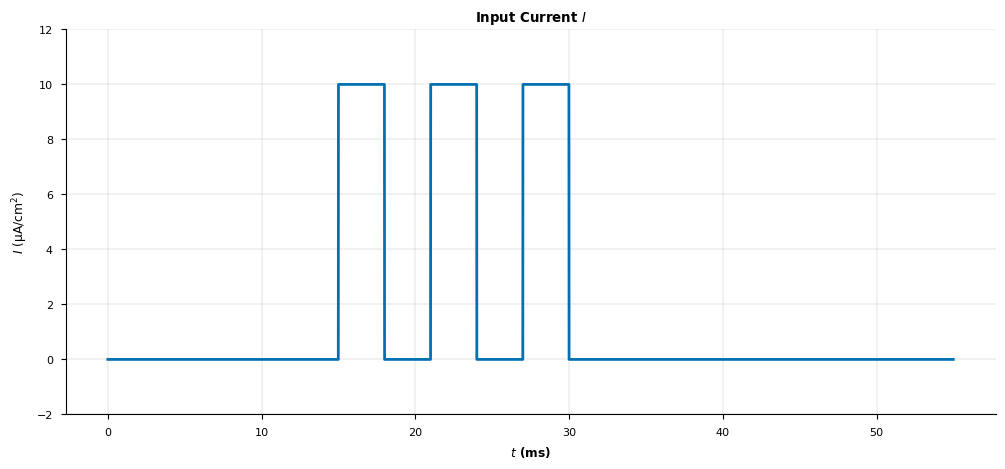

In [16]:
Voltage_refractory,m_refractory,h_refractory,n_refractory,I_refractory,Time_refractory = run_simulation(
    flag = 'refractory'
)

plot_membrane_potential(Time = Time_refractory, Voltage = Voltage_refractory)
plot_current(Time = Time_refractory, Current = I_refractory)

Text(0.5, 1.0, 'Ion Channel Activation')

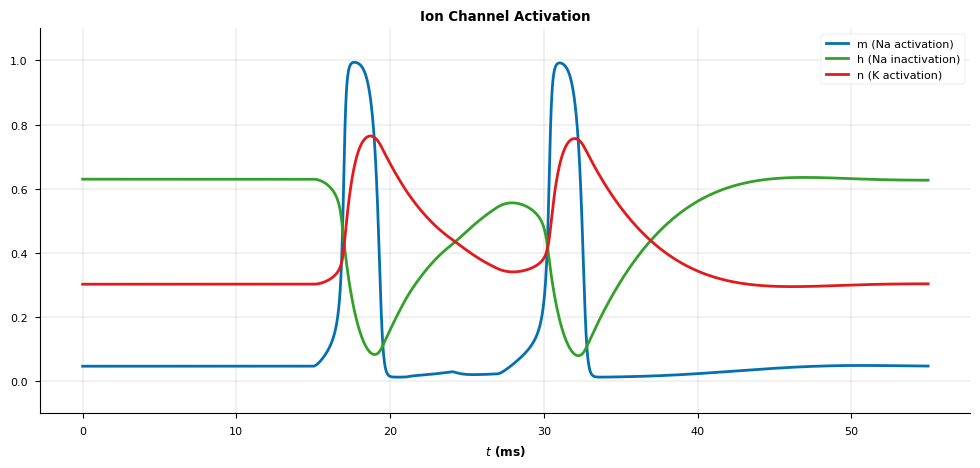

In [17]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time_refractory, m_refractory)
plt.plot(Time_refractory, h_refractory)
plt.plot(Time_refractory, n_refractory)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')

## Bursting

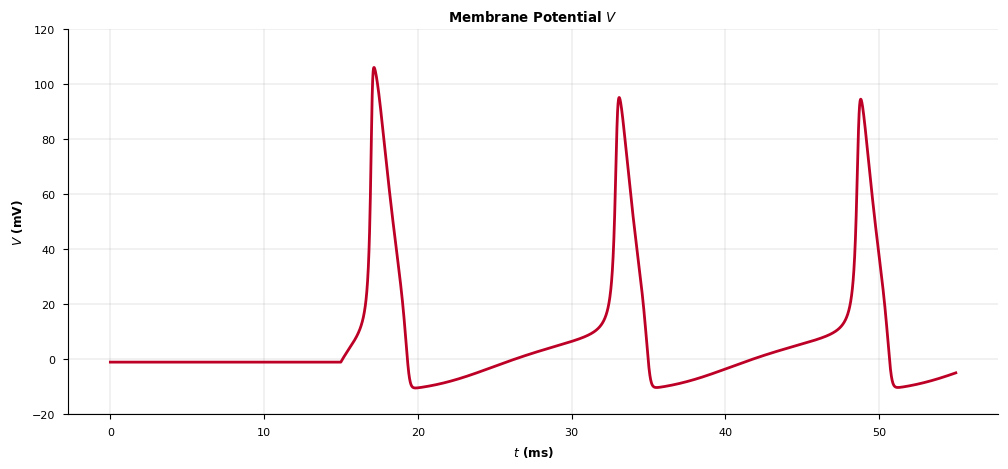

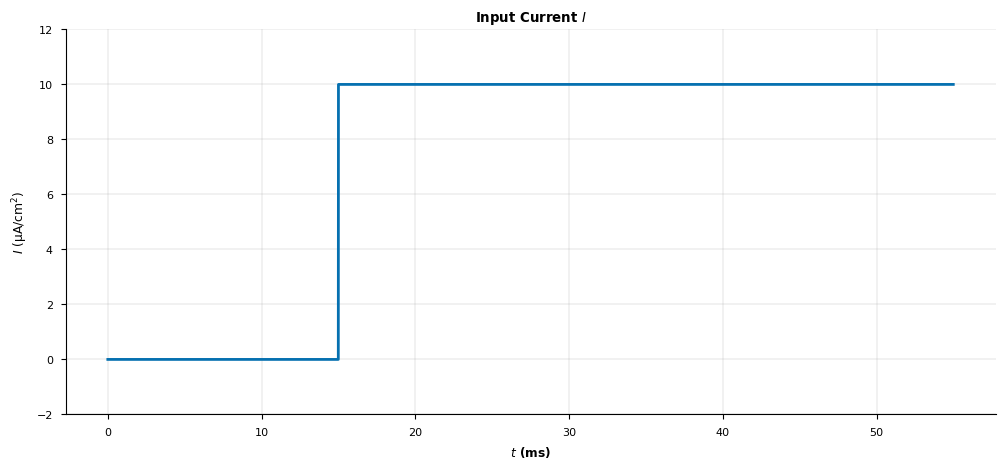

In [18]:
Voltage_burst,m_burst,h_burst,n_burst,I_burst,Time_burst = run_simulation(flag = 'burst')

plot_membrane_potential(Time = Time_burst, Voltage = Voltage_burst)
plot_current(Time = Time_burst, Current = I_burst)

Text(0.5, 1.0, 'Ion Channel Activation')

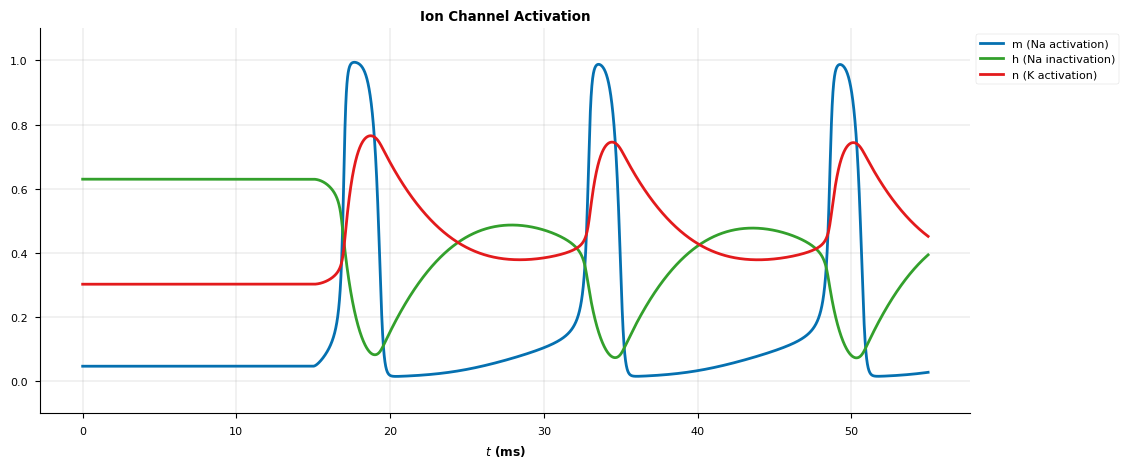

In [19]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time_burst, m_burst)
plt.plot(Time_burst, h_burst)
plt.plot(Time_burst, n_burst)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')